In [1]:
# GPU Reset if needed

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# Disable CUDA for TF 2.x

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [3]:
# Mount Google Drive if running on Google Colab

from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/bert/')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/bert


In [4]:
# List current directory

#!dir

In [5]:
# Remove current logs

#!rm -rf logs

In [6]:
# Import Tensorflow and related libraries

import tensorflow

print("Tensorflow precision mode : " + tensorflow.keras.backend.floatx())

# # Set Tensorflow precision mode to 'float16' to speedup with newer GPU
# tensorflow.keras.backend.set_floatx('float32')

# print("Tensorflow precision mode (after change) : " + tensorflow.keras.backend.floatx())

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Input

from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

print("TensorFlow version : " + tensorflow.__version__)

import numpy as np
print("Numpy version : " + np.version.version)

import pandas as pd
print("Pandas version : " + pd.__version__)

Tensorflow precision mode : float32
TensorFlow version : 2.8.0
Numpy version : 1.21.5
Pandas version : 1.3.5


In [7]:
# Display available GPUs

physical_devices = tensorflow.config.list_physical_devices(('GPU'))
for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [8]:
# Show GPU status

!nvidia-smi

Thu Feb 24 17:45:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# Fix for "CUDA_ERROR_ILLEGAL_ADDRESS"

# Ref : https://github.com/tensorflow/tensorflow/issues/40814#issuecomment-663838196

os.environ['TF_CUDNN_DETERMINISTIC']='1'

In [10]:
# Enable Memory Growth

try:
    if physical_devices != []:
        tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
        physical_devices[0]
except:
    print("error")      

In [11]:
# Global Parameters

author_list = ['Charles Dickens','Jane Austen','Sir Arthur Conan Doyle','George Eliot','Jules Verne']
seed_number = 18
dataset_file  = "dataset.csv"
validation_dataset_file  = "validation_dataset.csv"

# For 3 GB VRAM : 
# batch_size = 2 when seq_length = 128, otherwise "out of memory"
# Typical single epoch runtime = 20 mins

batch_size = 2 # number of batch size
epochs = 2 # number of maximum epochs to run
seq_length = 300 # BERT Model sequence length
dropout_value = 0.1 # Dropout layer value for Model
init_lr = 3e-5 # Initial learning rate

In [12]:
# Reading validation data (from seperate books)

validation_data = pd.read_csv(validation_dataset_file, usecols = ['author','text'])
X_val_2 = validation_data.text
y_val_2 = validation_data.author

In [13]:
# Reading training/test/validation data

data = pd.read_csv(dataset_file, usecols = ['author','text'])

In [14]:
#data.sample(5)

In [15]:
from sklearn.model_selection import train_test_split

# Train, Test, Validation Spit ratios 60%, 20%, 20% 

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["author"], test_size=0.2, random_state=2000)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=seed_number) # 0.25 x 0.8 = 0.2

In [16]:
print("Number of training data:",len(X_train))
print("Number of test data:",len(X_test))
print("Number of validation data (from same books):",len(X_val))
print("Number of validation data (from seperate books):",len(X_val_2))
print("Number of max characters in training dataset:",max(X_train.apply(len)))

Number of training data: 15000
Number of test data: 5000
Number of validation data (from same books): 5000
Number of validation data (from seperate books): 4000
Number of max characters in training dataset: 370


In [17]:
# Encoding label text to integeres

label_tokenizer = LabelEncoder()
label_tokenizer.fit(author_list)
label_index = label_tokenizer.classes_

y_train_sequences = np.array(label_tokenizer.transform(y_train))
y_test_sequences = np.array(label_tokenizer.transform(y_test))
y_val_sequences = np.array(label_tokenizer.transform(y_val))
y_val_sequences_2 = np.array(label_tokenizer.transform(y_val_2))

In [18]:
label_index

array(['Charles Dickens', 'George Eliot', 'Jane Austen', 'Jules Verne',
       'Sir Arthur Conan Doyle'], dtype='<U22')

### BERT Model

In [19]:
# BERT Model v4
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [20]:
# Useful resources on BERT

# https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
# https://www.tensorflow.org/guide/keras/functional
# https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [21]:
!pip install tensorflow_text==2.8.0rc0
!pip install tf-models-official==2.8.0

     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 462 kB 34.9 MB/s 
     |████████████████████████████████| 2.2 MB 5.2 MB/s 
     |████████████████████████████████| 234 kB 42.1 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 4.9 MB 29.3 MB/s 
     |████████████████████████████████| 636 kB 41.7 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 1.1 MB 26.2 MB/s 
     |████████████████████████████████| 352 kB 44.2 MB/s 
     |████████████████████████████████| 47.7 MB 2.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=d773dbcc95dbc3257f186b7b4e3d29985ed87833f1f8c813394f8c0ef93c8e0f
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c

In [22]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [23]:
# Preprocessor
# Ref : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [24]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [25]:
text_inputs = [tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string)]

In [26]:
tokenize = hub.KerasLayer(preprocessor.tokenize)

In [27]:
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

In [28]:
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))

In [29]:
encoder_inputs = bert_pack_inputs(tokenized_inputs)

In [30]:
print(encoder_inputs)

{'input_word_ids': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_1')>, 'input_mask': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_1')>, 'input_type_ids': <KerasTensor: shape=(None, 300) dtype=int32 (created by layer 'keras_layer_1')>}


In [31]:
# Alternative method to use if seq_length is fixed to default value:

# text_inputs = tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string)
# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder_inputs = preprocessor(text_inputs)

In [32]:
# bert_en_uncased_L-12_H-768_A-12
# Ref: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [33]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)

In [34]:
outputs = encoder(encoder_inputs)

In [35]:
pooled_output = outputs["pooled_output"]      # [batch_size, 768].

In [36]:
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [37]:
# Ref: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [38]:
bert_output = sequence_output

In [39]:
bert_intput = text_inputs

Model: "nlp_bert_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 300),                                                      
                                 'input_mask': (Non                                               
                                e, 300),                                                

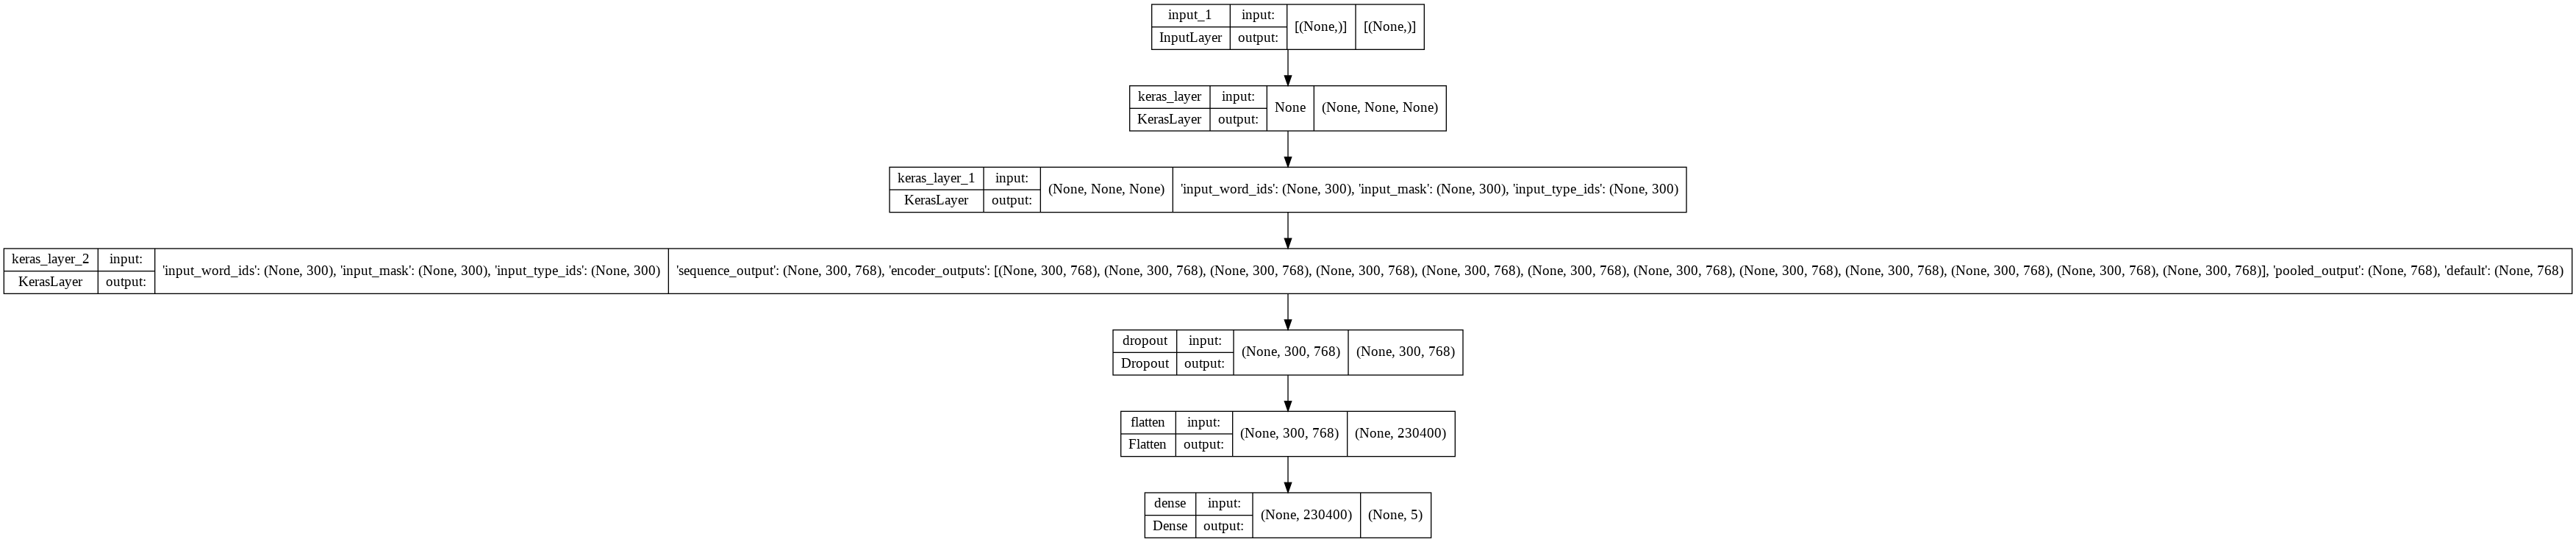

In [40]:
# define new model

dropout = tensorflow.keras.layers.Dropout(dropout_value)(bert_output)
flatten = tensorflow.keras.layers.Flatten()(dropout) 
model_output = tensorflow.keras.layers.Dense(5, activation='softmax')(flatten)

model = tensorflow.keras.Model(bert_intput, model_output)

model._name = "nlp_bert_" + str(seed_number) 
model.summary()

# Save the model as a png file
plot_model(model, to_file=model._name +'.png', show_shapes=True, show_layer_names=True)

In [41]:
# Show the trainable status of the layers

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 keras_layer False
2 keras_layer_1 False
3 keras_layer_2 True
4 dropout True
5 flatten True
6 dense True


In [42]:
# Define Optimizer

steps_per_epoch = int(len(X_train)/batch_size) #tensorflow.data.experimental.cardinality(data_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
print(steps_per_epoch,num_train_steps,num_warmup_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

7500 15000 1500


In [43]:
# Compile the model

model.compile(
    #optimizer=tensorflow.keras.optimizers.Adam(learning_rate=3e-5),
    #optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [44]:
# Tensorboard parameters

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [45]:
# Use best weights for the model

early_stopping_monitor = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [46]:
# Training the model
# callbacks are not used : early_stopping_monitor (to speed up), tensorboard_callback (has a bug with BERT)

history = model.fit(X_train, y_train_sequences, epochs=epochs, batch_size = batch_size, shuffle = True, callbacks=[], validation_data=(X_test , y_test_sequences ),)

Epoch 1/2
7500/7500 [==============================] - 3185s 421ms/step - loss: 0.9669 - accuracy: 0.7923 - val_loss: 0.7275 - val_accuracy: 0.8838
Epoch 2/2
7500/7500 [==============================] - 3155s 421ms/step - loss: 0.2520 - accuracy: 0.9597 - val_loss: 0.6057 - val_accuracy: 0.9192


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


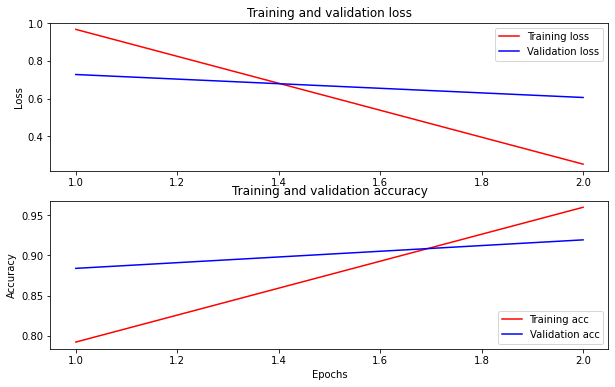

In [47]:
# Plot the accuracy and loss over time 
# Reusing sample code from : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

#print(loss)

epochs_number = range(1, (epochs) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs_number, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_number, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_number, acc, 'r', label='Training acc')
plt.plot(epochs_number, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [48]:
# Show tensorboard

# %load_ext tensorboard
# %tensorboard --logdir logs/fit
#%reload_ext tensorboard # just in case tensorboard didn't refresh

In [49]:
# Function to generate accuracy report

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

def accuracy_report(X_val_seq,y_val_seq):
    # Calculate preditions for the validation dataset

    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    y_pred = model.predict([X_val_seq])
    y_pred = np.argmax(y_pred, axis=1)
    #len(y_pred)

    y_true= y_val_seq
    #len(y_true)

    # Convert the true and predicted labels into arrays
    true_categories = label_tokenizer.inverse_transform(y_true)
    predicted_categories = label_tokenizer.inverse_transform(y_pred)
    # print(predicted_categories)

    # Generate confusion matrix
    cnf_matrix = confusion_matrix(true_categories,predicted_categories,  normalize='pred')

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=label_index)
    disp = disp.plot(cmap='Reds', xticks_rotation=45)
    plt.show()

    print("Accuracy for validation split: " ,accuracy_score(y_true, y_pred))
    print( "F1_score: " + str(f1_score(y_true, y_pred, average='micro')))

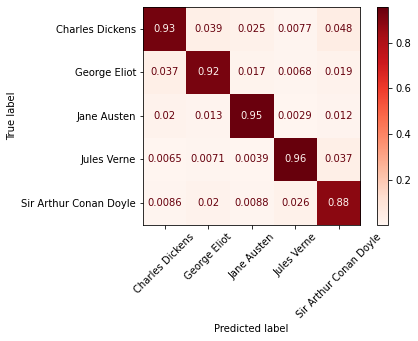

Accuracy for validation split:  0.927
F1_score: 0.927


In [50]:
# accuracy_report for same books

accuracy_report(X_val,y_val_sequences)

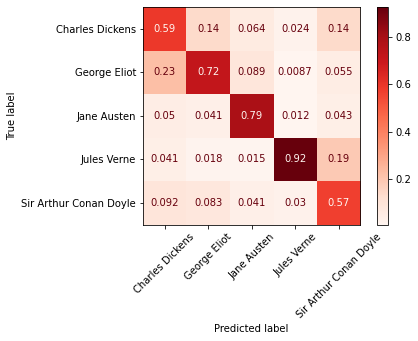

Accuracy for validation split:  0.69625
F1_score: 0.69625


In [51]:
# accuracy_report for seperate books

accuracy_report(X_val_2,y_val_sequences_2)

In [52]:
model.summary()

Model: "nlp_bert_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 300),                                                      
                                 'input_mask': (Non                                               
                                e, 300),                                                

In [53]:
# Saving final model for future use

#model.save("bert_5.h5", save_format='h5')
#tensorflow.keras.models.save_model(model,model._name)

In [54]:
#!tar czf bert_epoch5_adamw_compress.tar.gz bert_epoch5_adamw/

In [55]:
!nvidia-smi

Thu Feb 24 19:40:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    73W / 149W |   4296MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
model.save(model._name, include_optimizer=False)


INFO:tensorflow:Assets written to: nlp_bert_18/assets


INFO:tensorflow:Assets written to: nlp_bert_18/assets


In [57]:
#!tar czf bert_no_optimizer.tar.gz bert_no_optimizer/

In [58]:
# Reloading model

#reloaded_model = tensorflow.saved_model.load("bert_no_optimizer")

In [59]:
# Comparing results of model in memory and reloaded model

#text_string = X_val.iloc[0]

In [60]:
# Correct result

#y_val.iloc[0]

In [61]:
#model_result = model(tensorflow.constant([text_string]))

In [62]:
#reloaded_model_result = reloaded_model(tensorflow.constant([text_string]))

In [63]:
# Result from model in memory

#label_index[np.argmax(model_result, axis=1)]

In [64]:
# Result from reloaded model

#label_index[np.argmax(reloaded_model_result, axis=1)]